In [1]:
import os, sys
import numpy as np
from math import *
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf

from graph_nets import graphs
import networkx as nx
from graph_nets import utils_tf

from graph_network import EncodeProcessDecode

2021-10-20 12:40:13.642581: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Prepare the data

In [2]:
data_dir = 'tmp_datasets/'

feature_description = {'group_id': tf.io.FixedLenFeature([], tf.int64),
                        'timestep': tf.io.FixedLenFeature([], tf.int64),
                        'parameter_vector': tf.io.FixedLenSequenceFeature([], tf.float32,allow_missing=True),
                        'pos': tf.io.FixedLenFeature([], tf.string),
                        'vel': tf.io.FixedLenFeature([], tf.string)}


records_dataset =  tf.data.TFRecordDataset(tf.data.Dataset.list_files([data_dir + filename for filename in os.listdir(data_dir)]))


def _parse_record(x):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(x, feature_description)

parsed_records_dataset = records_dataset.map(_parse_record)

def _parse_tensor(x):
    output = {'group_id': x['group_id'],
                'timestep': x['timestep'],
                'parameter_vector': x['parameter_vector'],
                'pos': tf.io.parse_tensor(x['pos'],out_type=tf.float32),
                'vel': tf.io.parse_tensor(x['vel'],out_type=tf.float32)}
    return output

parsed_tensors_dataset = parsed_records_dataset.map(_parse_tensor)
parsed_tensors_dataset = parsed_tensors_dataset.shuffle(10000, reshuffle_each_iteration=True)
parsed_tensors_dataset = parsed_tensors_dataset.batch(4)


2021-10-20 12:40:14.602191: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-20 12:40:14.602811: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-20 12:40:14.641247: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-20 12:40:14.641632: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro P1000 computeCapability: 6.1
coreClock: 1.4805GHz coreCount: 5 deviceMemorySize: 3.92GiB deviceMemoryBandwidth: 74.65GiB/s
2021-10-20 12:40:14.641660: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-10-20 12:40:14.643587: I tensorflow/stream_executor/platform/default/dso_lo

## Preprocess positions and velocities into a graph tuple

In [3]:
interaction_radius = 15.0
L = 200
def preprocess_data(databatch):
    
    # node features xpos, ypos, xvel, yvel
    # edge features distance, rel angle to receiver
    X = databatch['pos']
    V = databatch['vel']
    
    Xx = tf.expand_dims(X[...,0],-1)
    dx = -Xx + tf.linalg.matrix_transpose(Xx)
    dx = tf.where(dx>0.5*L, dx-L, dx)
    dx = tf.where(dx<-0.5*L, dx+L, dx)

    Xy = tf.expand_dims(X[...,1],-1)
    dy = -Xy + tf.linalg.matrix_transpose(Xy)
    dy = tf.where(dy>0.5*L, dy-L, dy)
    dy = tf.where(dy<-0.5*L, dy+L, dy)



    A = tf.expand_dims(tf.math.atan2(V[...,1],V[...,0]),-1)
    angle_to_neigh = tf.math.atan2(dy, dx)

    rel_angle_to_neigh = angle_to_neigh - A

    dist = tf.math.sqrt(tf.square(dx)+tf.square(dy))

    adj_matrix = tf.where(dist<interaction_radius, tf.ones_like(dist,dtype=tf.int32), tf.zeros_like(dist,dtype=tf.int32))
    adj_matrix = tf.linalg.set_diag(adj_matrix, tf.zeros(tf.shape(adj_matrix)[:2],dtype=tf.int32))
    sender_recv_list = tf.where(adj_matrix)
    n_edge = tf.reduce_sum(adj_matrix, axis=[1,2])
    n_node = tf.ones_like(n_edge)*tf.shape(adj_matrix)[-1]

    senders = sender_recv_list[:,1] + sender_recv_list[:,0]*tf.shape(adj_matrix,out_type=tf.int64)[-1]
    receivers = sender_recv_list[:,2] + sender_recv_list[:,0]*tf.shape(adj_matrix,out_type=tf.int64)[-1]


    edge_distance = tf.expand_dims(tf.gather_nd(dist,sender_recv_list),-1)
    edge_x_distance =  tf.expand_dims(tf.gather_nd(tf.math.cos(rel_angle_to_neigh),sender_recv_list),-1)  # relative to sender heading
    edge_y_distance =  tf.expand_dims( tf.gather_nd(tf.math.sin(rel_angle_to_neigh),sender_recv_list),-1)  # relative to sender heading


    edges = tf.concat([edge_distance,edge_x_distance,edge_y_distance],axis=-1)

    node_positions = tf.reshape(X,(-1,2))
    node_velocities = tf.reshape(V,(-1,2))

    nodes = tf.concat([node_positions,node_velocities],axis=-1)

    gn = graphs.GraphsTuple(nodes=nodes,edges=edges,globals=None,receivers=receivers,senders=senders,n_node=n_node,n_edge=n_edge)
    gn = utils_tf.set_zero_global_features(gn,1)
    
    return gn

## Set up the optimizer and the loss function

In [4]:
min_lr = 1e-6
lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4 - min_lr,
                                decay_steps=int(5e6),
                                decay_rate=0.1) #+ min_lr
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

loss_function = tf.keras.losses.MeanSquaredError()

In [5]:
epd = EncodeProcessDecode(latent_size=128,mlp_hidden_size=128,mlp_num_hidden_layers=2,num_message_passing_steps=10,output_size=1)

In [6]:
def train_step(databatch):
    input_graphs = preprocess_data(databatch)
    target = databatch['parameter_vector'][:,2]
    
    with tf.GradientTape() as tape:
        predictions = epd(input_graphs)
        loss_value = loss_function(target,predictions)
    grads = tape.gradient(loss_value, epd.trainable_variables)
    optimizer.apply_gradients(zip(grads, epd.trainable_variables))
    return loss_value

## Run the training

In [ ]:
epochs = 20

for epoch in range(epochs):
    pbar = tqdm(parsed_tensors_dataset)

    # Iterate over the batches of the dataset.
    for d in  pbar:
        loss_value = train_step(d).numpy()
        pbar.set_description("Loss %f" % loss_value)
        

0it [00:00, ?it/s]2021-10-20 12:40:49.663712: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-20 12:40:49.681159: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3299990000 Hz
2021-10-20 12:40:49.932292: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-10-20 12:40:50.086458: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Loss 54.347187: : 27it [00:04,  6.42it/s] 

In [131]:
pred_list = []
true_values = []
count=0
for databatch in tqdm(parsed_tensors_dataset):
    true_values.append(databatch['parameter_vector'][:,2].numpy())
    input_graphs = preprocess_data(databatch)
    predictions = epd(input_graphs)
    pred_list.append(np.squeeze(predictions.numpy()))
    count+=1

    if count == 1000: break
pred_vals = np.array(pred_list).flatten()
true_vals = np.array(true_values).flatten()




999it [00:48, 20.61it/s]


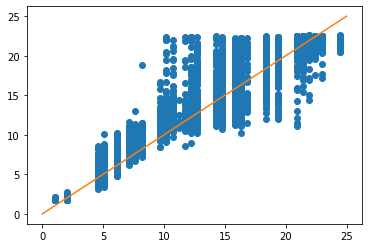

In [132]:
plt.plot(true_vals,pred_vals,'o')
xx = np.linspace(0,25,10)
plt.plot(xx,xx)
plt.show()